# Double Well Potential Symmetry Visualization

In this notebook we will perform symmetry group visualization on some double well potential data.

The imports for this one are quite numerous as we are doing the analysis piece by piece. Once there is a bridge between group detection and generator extraction I will add some generalzed methods for doing some of this automatically. Let's quickly mention what we are importing.

1. The class for a Double Well Potential. This is just for some test data generation.
2. DenseModel is a class written to take care of setting up and deploying a neural network.
3. DataCluster is reponsible for taking raw potential data and partitioning it into classes for the classification problems.
3. Group detection performs the TSNE reduction and finds our symmetry groups

from symdet.test_systems.double_well_potential import DoubleWellPotential
from symdet.models.dense_model import DenseModel
from symdet.symmetry_groups.data_clustering import DataCluster
from symdet.symmetry_groups.group_detection import GroupDetection

In [1]:
import symdet
import matplotlib.pyplot as plt

###  Preparing data
So you want to prepare some simple data from a double well potential so that we can identify some symmetry groups. Luckily, we were prepared for this scenario and wrote a class just for you!

In [2]:
double_well_potential = symdet.DoubleWellPotential(a=2.4)

As simple as that we have a double well potential. But we can also take a look at it.

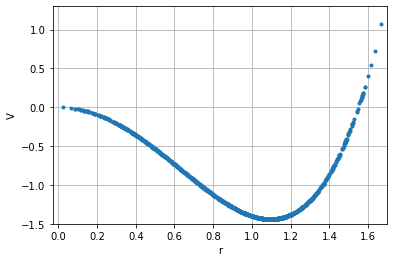

In [3]:
double_well_potential.plot_data()

### Preparing the classes

We now have to cluster the data to set up the machine learning problem for later. We define the clusters using the value range and bin operation. In this case we are binning the data in clusters of [ k/5 -1e-3, k/5 + 1e-3 ] with k in [-5, 5]. We will also visualize the clusters on the original data to aid in understanding how it was chosen.

In [4]:
double_well_potential.build_clusters(representatives=1500)

Loading additional data.


100%|████████████████████████████████| 11/11 [00:00<00:00, 370.36it/s]


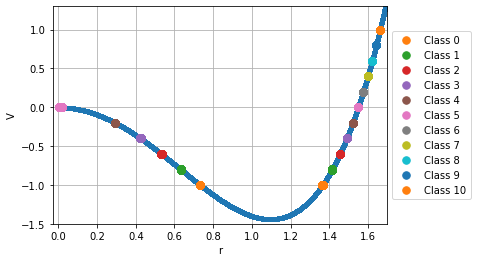

In [5]:
double_well_potential.plot_clusters()

### Preparing the model

We want to use a deep and wide neural network so as to encode a high dimensional representation. 

In [6]:
model = symdet.DenseModel(n_layers=7,
                          units=80,
                          epochs=10,
                          batch_size=64,
                          lr=0.00025)

### Running the analysis

The next steps are to define a group detection object with the cluster object we used earlier as well as the model to use in training.

We then simply run the symmetry detection and can visualize the symmetry relationship.

0
tf.Tensor(
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]], shape=(1500, 1), dtype=float32)
tf.Tensor(
[[0.32027608 1.3270773 ]
 [0.15088025 0.71712226]
 [0.48702756 0.5473976 ]
 ...
 [0.31052074 0.66307735]
 [0.68569434 0.2577942 ]
 [0.70457155 0.20125885]], shape=(1500, 2), dtype=float32)
1
tf.Tensor(
[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]], shape=(1500, 1), dtype=float32)
tf.Tensor(
[[0.7850773  1.1763347 ]
 [0.36858654 0.51346076]
 [0.38445932 1.3609657 ]
 ...
 [0.4642851  1.3357935 ]
 [0.43836233 0.45655498]
 [0.22908269 1.3954805 ]], shape=(1500, 2), dtype=float32)
2
tf.Tensor(
[[2.]
 [2.]
 [2.]
 ...
 [2.]
 [2.]
 [2.]], shape=(1500, 1), dtype=float32)
tf.Tensor(
[[0.27737197 0.45405886]
 [0.06850777 0.52810365]
 [1.2871039  0.6784493 ]
 ...
 [0.33405972 0.4142998 ]
 [0.4793766  0.23265877]
 [0.57924575 1.3347168 ]], shape=(1500, 2), dtype=float32)
3
tf.Tensor(
[[3.]
 [3.]
 [3.]
 ...
 [3.]
 [3.]
 [3.]], shape=(1500, 1), dtype=float32)
tf.Tensor(
[[0.7649366  1.2786707 ]
 [0.26207694

129/129 [==============================] - 0s 3ms/step - loss: 0.0631 - acc: 1.0000 - val_loss: 0.0621 - val_acc: 1.0000
Epoch 8/10
129/129 [==============================] - 0s 3ms/step - loss: 0.0593 - acc: 1.0000 - val_loss: 0.0575 - val_acc: 1.0000
Epoch 9/10
129/129 [==============================] - 0s 3ms/step - loss: 0.0568 - acc: 1.0000 - val_loss: 0.0552 - val_acc: 1.0000
Epoch 10/10
129/129 [==============================] - 0s 3ms/step - loss: 0.0544 - acc: 1.0000 - val_loss: 0.0524 - val_acc: 1.0000
Epoch 1/10
129/129 [==============================] - 0s 3ms/step - loss: 0.0520 - acc: 1.0000 - val_loss: 0.0515 - val_acc: 1.0000
Epoch 2/10
129/129 [==============================] - 0s 3ms/step - loss: 0.0504 - acc: 1.0000 - val_loss: 0.0491 - val_acc: 1.0000
Epoch 3/10
129/129 [==============================] - 0s 3ms/step - loss: 0.0487 - acc: 1.0000 - val_loss: 0.0474 - val_acc: 1.0000
Epoch 4/10
129/129 [==============================] - 0s 3ms/step - loss: 0.0470 - acc

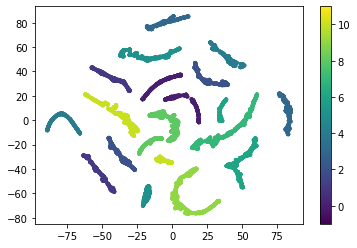

In [7]:
sym_detector = symdet.GroupDetection(model, double_well_potential.clustered_data)
point_cloud = sym_detector.run_symmetry_detection(plot=True)

So now we can analyze our model! We see for the darker colours that there are always two distinct instances corresponding to the symmetry between these radial values. The duplication of these colours means that this is a symmetry group. The test now is to identify the radial values in these clusters and pass them to the generator extraction methods to characterize them.

In [8]:
point_cloud.keys()

dict_keys([1.0, 2.0, 3.0, 4.0, 5.0])

We see that the clustering has worked relatively well. This is where some caution is advised in terms of simply parsing this data along to the generator detection. If you see that one of these groups should likely not be in the set then it should be parsed along to the generator extraction stage. Alternatively, you can use a different approach for identifying the sets in the symmetry representation. In the next update we will parse this data to the generator extraction algorithm in order to get the generators of this detected symmetry group.